In [1]:
from sources.vgg16 import VGG16
# from sources.InceptionV3 import InceptionV3
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
from wandb.keras import WandbMetricsLogger

In [2]:
import wandb
wandb.init(
    project="brain-tumor-classification",
    name="VGG16",	
    config={
        "learning_rate": 0.0001,
        "epochs": 10,
        "batch_size": 10,
        "loss_function": "categorical_crossentropy",
        "architecture": "VGG16_GP",
    }
    )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rijalsankalp (sankalpa). Use `wandb login --relogin` to force relogin


In [3]:
train_dir = "input/Training"
test_dir = "input/Testing"
target_size = (128, 128)
batch_size = 10

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.15)
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest', validation_split = 0.15)

In [5]:
og_train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset = 'training',
    shuffle=True
)

og_validation_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=1,
    class_mode='categorical',
    subset = 'validation',
    shuffle=True
)

Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.


In [6]:
aug_train_data = datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset = 'training',
    shuffle=True
)

aug_validation_data = datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=1,
    class_mode='categorical',
    subset = 'validation',
    shuffle=True
)


Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.


In [7]:
class_indices = og_train_data.class_indices
class_indices = {v:k for k, v in class_indices.items()}
print(class_indices)

{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


In [8]:
#two generators should be combined aferall
def combine_gen(*gens):
    while True:
        for g in gens:
            yield next(g)

In [9]:
train_steps = (len(og_train_data)+len(aug_train_data)) // batch_size
validation_steps = (len(og_validation_data)+len(aug_validation_data)) // batch_size

In [10]:
model = VGG16(input_shape=(128,128,3), num_classes=4).build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [11]:
num_epochs = 26
optimizer = tf.keras.optimizers.Adam(0.0001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])	

In [12]:
# Train the model on GPU
history = model.fit(combine_gen(og_train_data, aug_train_data),
                              steps_per_epoch=train_steps,
                              epochs=10,
                              validation_data= combine_gen(og_validation_data, aug_validation_data),
                              validation_steps = validation_steps,
                              callbacks=[WandbMetricsLogger(log_freq = "batch")]
                   )

filename = "savedmodels/brain_tumor_VGG16.h5"
# Save the trained model to disk
model.save(filename)

Epoch 1/10
97/97 [==============================] - 312s 3s/step - loss: 0.7685 - accuracy: 0.6990 - precision: 0.7929 - recall: 0.5722 - val_loss: 0.8784 - val_accuracy: 0.7368 - val_precision: 0.7919 - val_recall: 0.6901
Epoch 2/10
97/97 [==============================] - 283s 3s/step - loss: 0.5025 - accuracy: 0.8072 - precision: 0.8477 - recall: 0.7629 - val_loss: 0.6486 - val_accuracy: 0.7544 - val_precision: 0.7806 - val_recall: 0.7076
Epoch 3/10
97/97 [==============================] - 286s 3s/step - loss: 0.4434 - accuracy: 0.8485 - precision: 0.8822 - recall: 0.8103 - val_loss: 0.5016 - val_accuracy: 0.8187 - val_precision: 0.8405 - val_recall: 0.8012
Epoch 4/10
97/97 [==============================] - 277s 3s/step - loss: 0.2605 - accuracy: 0.9041 - precision: 0.9194 - recall: 0.8938 - val_loss: 0.7702 - val_accuracy: 0.7661 - val_precision: 0.7771 - val_recall: 0.7544
Epoch 5/10
97/97 [==============================] - 277s 3s/step - loss: 0.3126 - accuracy: 0.8928 - precisi

In [13]:
#collecting the test datset
test_data = datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

#y_pred = model.predict(test_data, callbacks=[WandbCallback(), tensorboard_callback])
y_pred = model.predict(test_data, callbacks=[WandbMetricsLogger(log_freq = "batch")])
# Convert the predicted probabilities to labels
y_pred_labels = tf.argmax(y_pred, axis=1)
y_true_labels = tf.constant(test_data.labels, dtype=tf.int64, shape=[1311,])
y_pred_labels = y_pred_labels.numpy().tolist()
y_true_labels = y_true_labels.numpy().tolist()

Found 1311 images belonging to 4 classes.
132/132 [==============================] - 96s 726ms/step


In [14]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score,log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true_labels, y_pred_labels, average='weighted')
cm = confusion_matrix(y_true_labels, y_pred_labels)
test_accuracy = accuracy_score(y_true_labels, y_pred_labels)
test_loss = log_loss(y_true_labels, y_pred)

In [15]:
wandb.log({
    "test_loss": test_loss,
    "test_precision": precision,
    "test_recall": recall,
    "test_f1_score": f1_score,
    "test_accuracy": test_accuracy,
    "roc" : wandb.plot.roc_curve( y_true=y_true_labels, y_probas=y_pred,
                        labels=['glioma', 'meningioma', 'no_tumor', 'pituitary'],
                        title="ROC"),
    "test_confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                            y_true=y_true_labels,
                                                            preds=y_pred_labels,
                                                            class_names=['glioma', 'meningioma', 'no_tumor', 'pituitary'],
                                                            title="Test Confusion Matrix")
})

In [16]:
wandb.finish()

batch/accuracy,▁▃▄▄▆▆▆▆▇▇▇▇▇██████▇████████▇▇▇█████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▆▅▄▄▃▃▃▂▂▃▂▂▂▁▂▁▂▂▁▂▁▁▁▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁
batch/precision,▃▁▁▃▅▃▄▄▆▆▆▆█▇▇▇██▇▇█▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇██
batch/recall,▁▄▄▅▆▆▇▇▇▇▇▇████████████████████████████
epoch/accuracy,▁▄▆▇▇██▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▂▂▁▂▂▁▁
epoch/precision,▁▄▅▇▇▇▇▇▇█


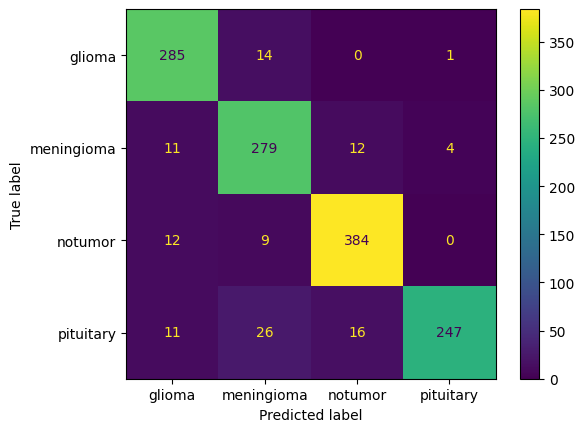

In [17]:
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['glioma','meningioma','notumor', 'pituitary'])
display.plot()